In [72]:
# Standard library for interacting with the OS (e.g., file paths)
import os
# NumPy for numerical operations and array handling
import numpy as np
# Pandas for data loading and manipulation (DataFrames)
import pandas as pd
# Matplotlib for plotting graphs and visualizations
import matplotlib.pyplot as plt
# TensorFlow for building and training the deep learning model
import tensorflow as tf
# Scikit-learn for model evaluation metrics
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
# Keras components for building the sequential model and its layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Input
# Keras utility for one-hot encoding the labels
from tensorflow.keras.utils import to_categorical
# Import the Keras callbacks for smarter training
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [73]:
# --- Dataset Constants ---

# Defines the prefixes for the 9 input signal files.
# This list is used to dynamically construct the file paths for loading the data.
INPUT_SIGNAL_TYPES = [
    "body_acc_x_",
    "body_acc_y_",
    "body_acc_z_",
    "body_gyro_x_",
    "body_gyro_y_",
    "body_gyro_z_",
    "total_acc_x_",
    "total_acc_y_",
    "total_acc_z_"
]

# Defines the human-readable names for the 6 output classes.
# This is used for interpreting and displaying the model's predictions.
LABELS = [
    "WALKING",
    "WALKING_UPSTAIRS",
    "WALKING_DOWNSTAIRS",
    "SITTING",
    "STANDING",
    "LAYING"
]


In [74]:
# Define constant strings for the subdirectories to make file paths easier to manage.
DATASET_PATH = "UCI HAR Dataset/"
TRAIN = "train/"
TEST = "test/"


#### Please download the test and training data form the URL - https://archive.ics.uci.edu/ml/machine-learning-databases/00240/UCI HAR Dataset.zip
#### Unzib the data just extrac UCI HAR Dataset folder and keep along with this Jupiter Notebook file.

In [4]:
def load_dataset(path):
    """
    Loads and preprocesses the HAR dataset from the specified root path.
    """
    print("Loading dataset...")

    # --- Load Training Data ---
    # Use a list comprehension to generate the full file paths for the 9 train signal files.
    X_train_signals_paths = [os.path.join(path, "train/Inertial Signals/", signal + "train.txt") for signal in INPUT_SIGNAL_TYPES]
    # Get the file path for the training labels.
    y_train_path = os.path.join(path, "train/y_train.txt")

    # Read each of the 9 signal files into a NumPy array using Pandas and store them in a list.
    # `delim_whitespace=True` handles the space-separated values in the files.
    X_train_list = [pd.read_csv(p, delim_whitespace=True, header=None).values for p in X_train_signals_paths]
    # Stack the list of 9 arrays (each shaped [samples, 128]) into a single 3D array.
    # The final shape will be (samples, timesteps, features) -> e.g., (7352, 128, 9).
    X_train = np.stack(X_train_list, axis=-1)

    # Load the training labels, flatten them into a 1D array, and subtract 1
    # to convert them from 1-based (1-6) to 0-based (0-5) indexing.
    y_train_df = pd.read_csv(y_train_path, header=None)
    y_train = y_train_df.values.flatten() - 1

    # --- Load Test Data ---
    # Repeat the exact same process for the test dataset.
    X_test_signals_paths = [os.path.join(path, "test/Inertial Signals/", signal + "test.txt") for signal in INPUT_SIGNAL_TYPES]
    y_test_path = os.path.join(path, "test/y_test.txt")

    X_test_list = [pd.read_csv(p, delim_whitespace=True, header=None).values for p in X_test_signals_paths]
    X_test = np.stack(X_test_list, axis=-1)

    y_test_df = pd.read_csv(y_test_path, header=None)
    y_test = y_test_df.values.flatten() - 1

    # --- One-Hot Encode Labels ---
    # Convert the integer labels (e.g., 2) into a binary vector format
    # (e.g., [0, 0, 1, 0, 0, 0]), which is required for the categorical_crossentropy loss function.
    n_classes = len(np.unique(y_train))
    y_train_one_hot = to_categorical(y_train, num_classes=n_classes)
    y_test_one_hot = to_categorical(y_test, num_classes=n_classes)

    print("Dataset loaded successfully.")
    # Return the processed train and test sets as a tuple.
    return (X_train, y_train_one_hot), (X_test, y_test_one_hot)

In [5]:
def build_model(n_timesteps, n_features, n_classes):
    """
    Builds a stacked LSTM model using the Keras Sequential API.
    """
    # Create a Sequential model, which is a linear stack of layers.
    model = Sequential([
        # Defines the expected input shape for the model.
        # This is (128 timesteps, 9 features) for our dataset.
        Input(shape=(n_timesteps, n_features)),

        # First LSTM layer with 32 units. This layer processes the input sequence.
        # `return_sequences=True` is essential for stacking RNN layers. It makes this
        # layer output the full sequence to the next layer, not just the final step.
        LSTM(32, return_sequences=True),

        # Second LSTM layer. It receives the sequence from the first LSTM layer.
        # It defaults to `return_sequences=False`, so it outputs only the result
        # from the final timestep, which summarizes the entire sequence.
        LSTM(32),

        # The final output layer. It's a standard Dense (fully-connected) layer.
        # It has `n_classes` (6) neurons, one for each activity.
        # 'softmax' activation converts the raw output scores into a probability
        # distribution, making it ideal for multi-class classification.
        Dense(n_classes, activation='softmax')
    ])
    # Return the constructed Keras model object.
    return model

In [6]:
# Load the data
(X_train, y_train), (X_test, y_test) = load_dataset(DATASET_PATH)

# Extract data dimensions
n_samples, n_timesteps, n_features = X_train.shape
n_classes = y_train.shape[1]

print(f"\nTraining data shape: {X_train.shape}")
print(f"Test data shape: {X_test.shape}")
print(f"Number of classes: {n_classes}")

# Build the Keras model
model = build_model(n_timesteps, n_features, n_classes)

# Compile the model.
# This step configures the model for training by specifying the optimizer,
# loss function, and metrics to monitor.
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy', # Use for one-hot encoded labels
    metrics=['accuracy']
)

# Print a summary of the model's architecture.
model.summary()

NameError: name 'DATASET_PATH' is not defined

In [ ]:
# --- Advanced Training with Callbacks ---

# Define the EarlyStopping callback.
# This will monitor the validation loss and stop training if it doesn't improve
# for 5 consecutive epochs ('patience=5').
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    verbose=1,
    restore_best_weights=True  # Restores model weights from the epoch with the best val_loss.
)

# Define the ReduceLROnPlateau callback.
# This will reduce the learning rate if the validation loss plateaus for
# 5 epochs ('patience=5').
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,          # Factor by which the learning rate will be reduced: new_lr = lr * factor
    patience=5,
    min_lr=0.0001,       # Lower bound on the learning rate.
    verbose=1
)

# Train the model with the new callbacks.
print("\nTraining model with callbacks...")
history = model.fit(
    X_train, y_train,
    epochs=100,          # Set the maximum number of epochs to 100.
    batch_size=64,
    validation_data=(X_test, y_test),
    verbose=1,
    # Pass the callbacks to the fit function in a list.
    callbacks=[early_stopping, reduce_lr]
)


Training model with callbacks...
Epoch 1/100
115/115 ━━━━━━━━━━━━━━━━━━━━ 6s 42ms/step - accuracy: 0.4656 - loss: 1.2650 - val_accuracy: 0.5409 - val_loss: 0.9864 - learning_rate: 0.0010
Epoch 2/100
115/115 ━━━━━━━━━━━━━━━━━━━━ 4s 36ms/step - accuracy: 0.6925 - loss: 0.7286 - val_accuracy: 0.6817 - val_loss: 0.6908 - learning_rate: 0.0010
Epoch 3/100
115/115 ━━━━━━━━━━━━━━━━━━━━ 4s 39ms/step - accuracy: 0.8009 - loss: 0.5171 - val_accuracy: 0.7777 - val_loss: 0.6200 - learning_rate: 0.0010
Epoch 4/100
115/115 ━━━━━━━━━━━━━━━━━━━━ 5s 41ms/step - accuracy: 0.8781 - loss: 0.3593 - val_accuracy: 0.7584 - val_loss: 0.6795 - learning_rate: 0.0010
Epoch 5/100
115/115 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step - accuracy: 0.9129 - loss: 0.2597 - val_accuracy: 0.8307 - val_loss: 0.5301 - learning_rate: 0.0010
Epoch 6/100
115/115 ━━━━━━━━━━━━━━━━━━━━ 5s 39ms/step - accuracy: 0.9106 - loss: 0.2572 - val_accuracy: 0.8531 - val_loss: 0.4533 - learning_rate: 0.0010
Epoch 7/100
115/115 ━━━━━━━━━━━━━━━━━━━━ 4

In [ ]:
# --- Evaluation and Visualization ---
print("\nEvaluating model...")
# Evaluate the final model performance on the test set.
final_loss, final_accuracy = model.evaluate(X_test, y_test, verbose=1)
print(f"\nFinal Test Loss: {final_loss:.4f}")
print(f"Final Test Accuracy: {final_accuracy:.4f}")


Evaluating model...
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.8924 - loss: 0.3553

Final Test Loss: 0.3553
Final Test Accuracy: 0.8924


In [ ]:
def plot_training_history(history):
    """
    Plots model accuracy and loss curves for training and validation.
    """
    # Create a new figure with a specified size for the plots.
    plt.figure(figsize=(12, 5))

    # --- Plot Accuracy ---
    # Create the first subplot (1 row, 2 columns, index 1).
    plt.subplot(1, 2, 1)
    # Plot the training accuracy history. `history.history` is a dictionary
    # containing the metrics recorded during training.
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    # Plot the validation accuracy history.
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    # Add titles and labels for clarity.
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend()

    # --- Plot Loss ---
    # Create the second subplot (1 row, 2 columns, index 2).
    plt.subplot(1, 2, 2)
    # Plot the training loss history.
    plt.plot(history.history['loss'], label='Train Loss')
    # Plot the validation loss history.
    plt.plot(history.history['val_loss'], label='Validation Loss')
    # Add titles and labels.
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()

    # Adjust the plot layout to prevent titles and labels from overlapping.
    plt.tight_layout()
    # Display the generated plots.
    plt.show()

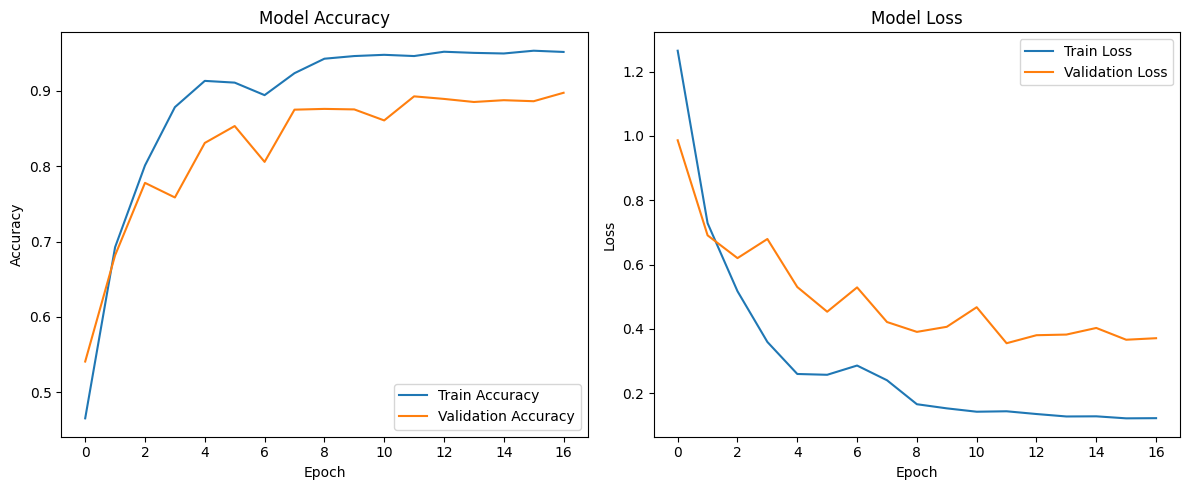

In [ ]:
# Plot training history
plot_training_history(history)

In [ ]:
# --- Get Predictions and Format for Evaluation ---
# Use the trained model to make predictions on the test set.
# The output `y_pred_one_hot` will be a 2D array where each row contains the
# probability distribution for the 6 classes (e.g., [0.1, 0.1, 0.7, 0.05, ...]).
y_pred_one_hot = model.predict(X_test)

# Convert the one-hot encoded predictions into single integer labels.
# `np.argmax` finds the index of the maximum value along each row (axis=1),
# which corresponds to the class with the highest predicted probability.
y_pred = np.argmax(y_pred_one_hot, axis=1)

# Convert the one-hot encoded true labels (`y_test`) back into single integer labels.
# This is done so `y_pred` and `y_true` are in the same format for direct comparison
# by the evaluation metrics (e.g., confusion_matrix).
y_true = np.argmax(y_test, axis=1)

93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step


In [ ]:
# --- Print Detailed Classification Metrics ---

# Print a header for this section of the output.
print("\nClassification Metrics:")

# Calculate and print the weighted precision score.
# Precision = True Positives / (True Positives + False Positives)
print(f"Precision: {precision_score(y_true, y_pred, average='weighted'):.4f}")

# Calculate and print the weighted recall score.
# Recall = True Positives / (True Positives + False Negatives)
print(f"Recall: {recall_score(y_true, y_pred, average='weighted'):.4f}")

# Calculate and print the weighted F1-score.
# F1-score is the harmonic mean of precision and recall, providing a balanced measure.
print(f"F1-score: {f1_score(y_true, y_pred, average='weighted'):.4f}")



Classification Metrics:
Precision: 0.8934
Recall: 0.8924
F1-score: 0.8922


In [ ]:
def plot_confusion_matrix(y_true, y_pred, class_names):
    """
    Generates and plots a normalized confusion matrix.
    """
    # Calculate the confusion matrix using the true and predicted labels.
    cm = confusion_matrix(y_true, y_pred)
    # Normalize the confusion matrix. Each row is divided by its sum to get percentages.
    # This is important for a fair comparison between classes of different sizes.
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    # Set up the plot figure.
    plt.figure(figsize=(10, 8))
    # Display the matrix as an image with a color map ('Blues').
    # `interpolation='nearest'` prevents blurring of the squares.
    plt.imshow(cm_normalized, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title("Normalized Confusion Matrix")
    plt.colorbar()

    # Create tick marks for the axes using the number of class names.
    tick_marks = np.arange(len(class_names))
    # Set the x-axis labels to the activity names, rotated for readability.
    plt.xticks(tick_marks, class_names, rotation=45)
    # Set the y-axis labels.
    plt.yticks(tick_marks, class_names)

    # Label the axes.
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    # Automatically adjust subplot params for a tight layout.
    plt.tight_layout()
    # Show the plot.
    plt.show()

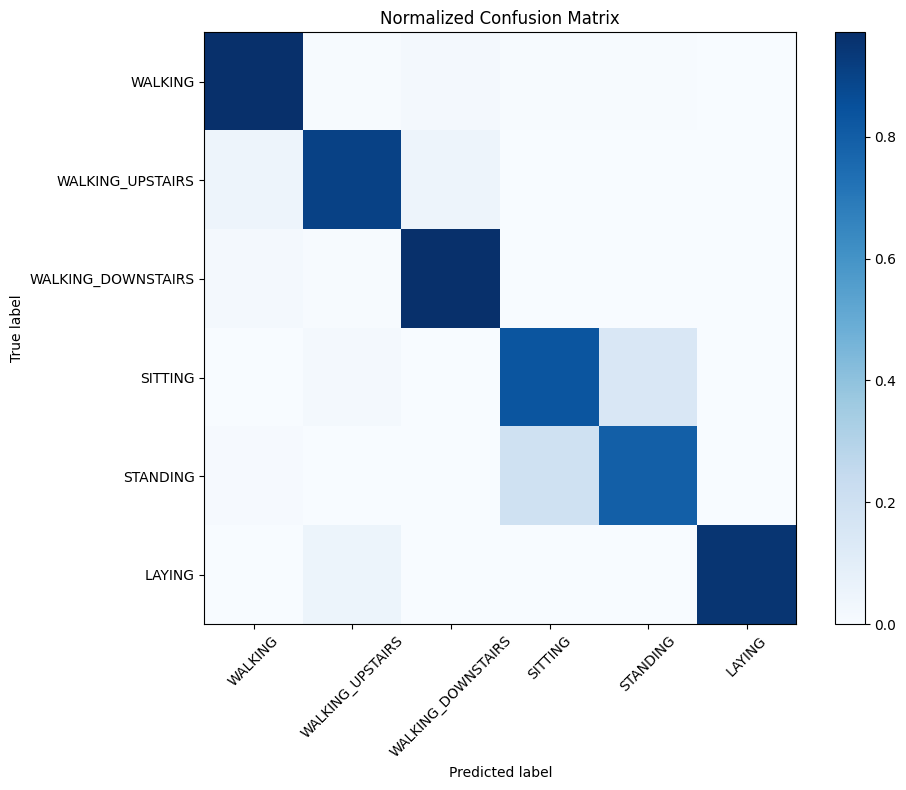

In [ ]:
# Plot the confusion matrix
plot_confusion_matrix(y_true, y_pred, LABELS)